In [ ]:
# !pip install torch_geometric==2.3.1

In [23]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import add_self_loops, degree

- 간단한 형태의 그래프 정의
  - `x` : feature matrix
    - 4개의 노드(0, 1, 2, 3)이 각각 2차원의 벡터로 임베딩되어 있다고 가정
  - `edge_index` : 그래프의 연결 상태
    - 양방향 그래프를 가정해서 0번 노드와 1번 노드가 연결되어 있으면 (`[0, 1]`), 1번 노드와 0번 노드도 연결되어 있음 (`[1, 0]`)

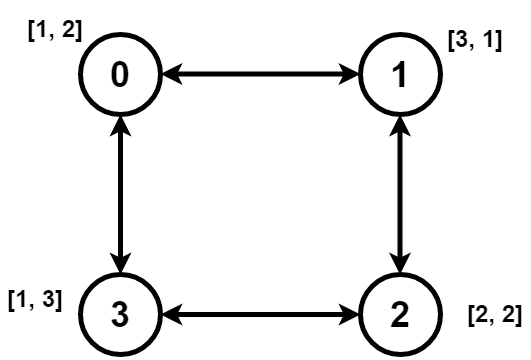

In [6]:
x = torch.tensor([[1, 2],
                  [3, 1],
                  [2, 2],
                  [1, 3]], dtype=torch.float)
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1],
                           [2, 3],
                           [3, 2],
                           [3, 0],
                           [0, 3]], dtype=torch.long).T

$\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{W}^{\top} \cdot \mathbf{x}_j^{(k-1)} \right) + \mathbf{b}$

- $\mathbf{x}_i^{(k)}$ : 노드 i의 k번째 레이어에서의 feature vector (column vector)
- $j \in \mathcal{N}(i) \cup \{ i \}$ - 노드 i에 이웃한 모든 노드($\mathcal{N}(i)$) + 노드 i까지 포함($\{i\}$)한 집합에 속한 노드 j에 대해 연산 수행
- $\\deg(i), \deg(j)$ : 노드 i와 j의 차수(=연결된 엣지의 개수)
- $\mathbf{W}^{\top}, \mathbf{b}$ : convolution layer의 학습 parameter

- 참고 링크
- https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

- `MessagePassing` : `torch.nn.Module`을 상속받아 구현된 메세지 전파 layer의 기본 class
- Convlution Layer 정의
  - `in_channels` : layer에 들어가기 전 노드의 임베딩 차원 (=$\mathbf{x}_i^{(k-1)}$의 차원)
  - `out_channels` : layer에서 나온 후 노드의 임베딩 차원 (=$\mathbf{x}_i^{(k)}$의 차원)
  - `self.lin` : $\mathbf{W}^{\top}$
  - `self.bias` : $\mathbf{b}$
  - `self.reset_parameters()` : 계산의 편의를 위해 `self.lin`은 [0.5, 0.3]으로, `self.bias`는 0.1로 초기화
  - `aggr='add'` : 이웃 노드로부터 전파된 메세지를 합치겠다는 의미($\sum$)

```python
class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        # Custom weight matrix
        custom_weight = torch.tensor([[0.5, 0.3]])
        self.lin.weight = torch.nn.Parameter(custom_weight)
        # Custom bias vector
        custom_bias = torch.tensor([0.1])
        self.bias = torch.nn.Parameter(custom_bias)
```

- `forward(self, x, edge_index)`
  - `x` : input으로 들어오는 노드들의 feature matrix
  - `edge_index` : input으로 들어오는 노드의 연결 상태
  - `add_self_loops` : troch_geometric에 구현된 함수로(`torch_geometric.utils.add_self_loops`), 자기 자신에게 연결되는 엣지 추가 (edge_index를 확인하면 [0,0], [1,1], [2,2], [3,3] 이 추가됨)
  - `x_transformed` : `self.lin`을 통과해 선형변환된 `x` (= 다른 노드로 전파될 메세지의 기본 크기(?))
  - `src`, `dst` : source, destination의 약자로 엣지가 src 노드로부터 dst 노드로 연결되어 있음을 의미
  - `degree` : troch_geometric에 구현된 함수로(`torch_geometric.utils.degree`), 각 노드의 차수를 계산
  - `deg_inv_sqrt` : $1/\sqrt{\deg(i)}$
  - `norm` : $1/(\sqrt{\deg(i)} \cdot \sqrt{\deg(j)})$. 연결된 엣지가 총 12개(기본 8개 + self loop 4개)이므로 각 엣지의 src 노드에 대한 coefficient 12개 필요함
  - `propagate` : `MessagePassing` class에서 정의된 method로, (자기 자신을 포함한) 이웃 노드로부터 전파되는 메세지를 계산. `propagate`함수를 호출하면 `message`, `aggregate`, `update`함수도 호출해 계산함. `message`함수로 다른 노드로부터 전파되는 메세지를 계산하고, `aggregate`함수로 그 메세지들을 합치며, `update`함수로 각 노드의 feature vector를 업데이트 한다.
  - `message` : `propagate`을 호출하면 같이 호출되는 함수. GCN 모델에서는 각 노드의 메세지를 normalize하기 때문에 앞서 구한 `norm` 벡터를 인자로 전해주는 `meesage`함수를 따로 정의
  - 마지막으로 결과물에 `self.bias`를 더해준다.

```python
    def forward(self, x, edge_index):
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x_transformed = self.lin(x)

        # Step 3: Compute normalization.
        src, dst = edge_index
        deg = degree(dst, x_transformed.size(1), dtype=x_transformed.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x_transformed, norm=norm)
        
        # Step 6: Apply a final bias vector.
        out += self.bias
        return out

    def message(self, x_j, norm):
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j
```

In [6]:
class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        # Custom weight matrix
        custom_weight = torch.tensor([[0.5, 0.3]])
        self.lin.weight = torch.nn.Parameter(custom_weight)
        # Custom bias vector
        custom_bias = torch.tensor([0.1])
        self.bias = torch.nn.Parameter(custom_bias)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops to the adjacency matrix.
        print("original edge_index")
        print(edge_index)
        print()
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        print("edge_index after adding self-loops")
        print(edge_index)
        print()

        # Step 2: Linearly transform node feature matrix.
        print("linearly transform feature matrix")
        print("input")
        print(x)
        x_transformed = self.lin(x)
        print("output")
        print(x_transformed)              
        print()
        
        # Step 3: Compute normalization.
        src, dst = edge_index
        deg = degree(dst, x_transformed.size(0), dtype=x_transformed.dtype)
        print('degree for each node')
        print(deg)
        print()
        deg_inv_sqrt = deg.pow(-0.5)

        print("normalization coeffecient for each node")
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]
        print(norm)
        print()

        # Step 4-5: Start propagating messages.
        print("propagate")
        out = self.propagate(edge_index, x=x_transformed, norm=norm)
        print("propagate output")
        print(out)
        print()
        
        # Step 6: Apply a final bias vector.
        print("apply bias")
        out += self.bias
        print(out)
        print()
        print("final output")
        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        print("messsage before noramlization")
        print(x_j)
        print("message after normalization")
        print(norm.view(-1, 1) * x_j)
        print()
        return norm.view(-1, 1) * x_j


cust_conv = CustomGCNConv(in_channels=2, out_channels=1)
print("custom weight")
print(cust_conv.lin.weight.data)
print("custom bias")
print(cust_conv.bias.data)
print()

x = torch.tensor([[1, 2],
                  [3, 1],
                  [2, 2],
                  [1, 3]], dtype=torch.float)
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1],
                           [2, 3],
                           [3, 2],
                           [3, 0],
                           [0, 3]], dtype=torch.long).T


print(cust_conv(x, edge_index))

weight
tensor([[0.5000, 0.3000]])
bias
tensor([0.1000])

original edge_index
tensor([[0, 1, 1, 2, 2, 3, 3, 0],
        [1, 0, 2, 1, 3, 2, 0, 3]])

edge_index after adding self-loops
tensor([[0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 2, 3],
        [1, 0, 2, 1, 3, 2, 0, 3, 0, 1, 2, 3]])

linearly transform feature matrix
input
tensor([[1., 2.],
        [3., 1.],
        [2., 2.],
        [1., 3.]])
output
tensor([[1.1000],
        [1.8000],
        [1.6000],
        [1.4000]], grad_fn=<MmBackward0>)

degree for each node
tensor([3., 3., 3., 3.])

normalization coeffecient for each node
tensor([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
        0.3333, 0.3333, 0.3333])

propagate
messsage before noramlization
tensor([[1.1000],
        [1.8000],
        [1.8000],
        [1.6000],
        [1.6000],
        [1.4000],
        [1.4000],
        [1.1000],
        [1.1000],
        [1.8000],
        [1.6000],
        [1.4000]], grad_fn=<IndexSelectBackward0>)
message after nor

- GCNConv와 비교

In [19]:
from torch_geometric.nn.conv import GCNConv

gcnconv = GCNConv(2, 1)
print(gcnconv.lin.weight)
print(gcnconv.bias)

Parameter containing:
tensor([[0.1458, 0.2799]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [20]:
custom_weight = torch.tensor([[0.5, 0.3]])
gcnconv.lin.weight = torch.nn.Parameter(custom_weight)

custom_bias = torch.tensor([0.1])
gcnconv.bias = torch.nn.Parameter(custom_bias)

print(gcnconv.lin.weight)
print(gcnconv.bias)

Parameter containing:
tensor([[0.5000, 0.3000]], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)


In [21]:
gcnconv(x, edge_index)

tensor([[1.5333],
        [1.6000],
        [1.7000],
        [1.4667]], grad_fn=<AddBackward0>)